In [2]:
import numpy as np
from lattice_actions import get_neighbors, get_neighbors_kdtree
from fibonacci import generate_vertices, generate_vertices_angles, generate_vertices_angles_mp
from multiprocessing import Pool
from lattice_optimisation import lattice_optimizer, angles_to_cartesian
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
import pickle

CPU_CORES = 16

In [3]:
from math import sqrt, sin, cos
import math

from pynverse import inversefunc

from pathos.pools import ProcessPool

from mpmath import mp

#import rpy2.robjects as robjects
#import rpy2.robjects.numpy2ri

import gmpy2

mp.dps = 100


def getFCCDist(n, d):
    if d != 3:
        print("no other than 3d case implemented")
        exit(-1)

    return ((4.0 / n) ** (1.0 / d)) / sqrt(2)


def estimatePointSpread(n, a):

    a = np.array(a)

    d = len(a) + 1

    minDist = d
    angle = mp.pi

    for p in range(1, int(n * getFCCDist(n, d)) + 3):
        diffs = (p * a) % 1
        for i, df in enumerate(diffs):
            if df > 0.5:
                diffs[i] = 1 - df

        dist = mp.sqrt((p / n) ** 2 + np.sum(diffs**2))

        if minDist > dist:
            minDist = dist
            angle = np.arccos(p / (n * float(dist)))

    # Only holds for d=3
    return minDist / getFCCDist(n, d), angle  # , pMin

memo = {}
memo[2] = 3

def findOptimalFibCoefficients(
    N,
    distThresh=0.95,
    angCenter=1.2,  # 0.7853981633974483096,
    angEps=0.1,
):
    p1, p2 = 2, 3
    memo[2] = 3

    while True:

        dist, ang = estimatePointSpread(N, [mp.sqrt(p1), mp.sqrt(p2)])

        if (dist > distThresh) and (abs(ang - angCenter) < angEps):
            return [mp.sqrt(p1), mp.sqrt(p2)]

        if memo[p1] == p2:
            p1 = 2
            if p2 not in memo:
                memo[p2] = int(gmpy2.next_prime(p2))
            p2 = memo[p2]
        else:
            p1 = memo[p1]



def getFibPoints(
    N,
    a=None,
    distThresh=0.95,
    angCenter=1.2,  # 0.7853981633974483096,
    angEps=0.1,
):

    # Finding good irrational numbers
    if a == -1:
        a = findOptimalFibCoefficients(N, distThresh, angCenter, angEps)
        print(f"-- got irrationals for {N} --")


    def getCartesianCoords(psi, theta, phi):
        return np.array(
            [
                cos(psi),
                sin(psi) * cos(theta),
                sin(psi) * sin(theta) * cos(phi),
                sin(psi) * sin(theta) * sin(phi),
            ]
        )

    # for n in range(N):
    def generatePoint(n):
        # Calculating Psi
        ps = inversefunc(
            lambda x: (x - (0.5 * sin(2 * x))), y_values=(math.pi * n) / (N)
        )

        # Calculating Theta
        th = mp.acos(1 - (2 * ((n * a[0]) % 1)))

        # Calculating Phi
        ph = 2 * mp.pi * ((n * a[1]) % 1)

        # out[n, :] = getCartesianCoords(ps, th, ph)
        return ps, float(th), float(ph)

    out = generate_vertices_angles_mp(N, irr = [float(a[0]), float(a[1])])
    #for i in range(N):
    #    out.append(generatePoint(i))

    
    return np.array(out)

In [4]:
def wrap_getFibPoints(dat):
        return getFibPoints(dat[0], a = dat[1])

def wrap_get_Vertices_angles(dat):
    return generate_vertices_angles(dat[0], irr = dat[1])

def compare_optimization(number_of_partitions : int, Start = 2**5, End = 2**15, irationals=None):

    irationals = -1 if irationals == None else irationals

    numbers = np.geomspace(Start, End, number_of_partitions, dtype=int, endpoint=True)
    angle_lattices = []
    if irationals == -1:
        for number in numbers:
            angle_lattices.append(wrap_getFibPoints([number, irationals]))
    else:
        for number in numbers:
            angle_lattices.append(generate_vertices_angles_mp(number, irr = irationals))
    print("-- angles done --")
    pool = Pool(CPU_CORES)
    opt_lattices_res = pool.map(lattice_optimizer, angle_lattices, chunksize=int(number_of_partitions/(CPU_CORES*2) + 1))
    
    return numbers, angle_lattices, opt_lattices_res

In [5]:
num = 100
#
#numbers, angles, res = compare_optimization(num, End = 2**20)
#with open("prime_opt_lattices.pickle", "wb") as file:
#    pickle.dump(res, file)

In [6]:
num = 100

#for arr in angles:
#    np.save(f"lattices\prime_optimised_angles_{arr.shape[0]}", arr)
prime_optimized_angles = []
for n in np.geomspace(2**5, 2**18, num, dtype=int, endpoint=True):
    prime_optimized_angles.append(np.load(f"lattices\prime_optimised_angles_{n}.npy"))

In [7]:
#pool = Pool(CPU_CORES)
#opt_lattices_res = pool.map(lattice_optimizer, prime_optimized_angles, chunksize=int(num/(CPU_CORES*2) + 1))

In [8]:
#with open("prime_opt_lattices.pickle", "wb") as file:
#    pickle.dump(opt_lattices_res, file)
with open("prime_opt_lattices.pickle", "rb") as file:
    prime_opt_lattices_res = pickle.load(file)

In [9]:
from su2_element import SU2_element
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices, generate_vertices_angles
from lattice_optimisation import lattice_optimizer, angles_to_cartesian, cartesian_to_angles, calc_mean_distance_angles_simple
from linear_discetisation import Linear_disc_points
from genz_recreate import gen_all_points
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r, La_Lb_commutator
from lattice_actions import calc_mean_distance
from derivative import angular_momentum, new_angular_momentum, new_angular_momentum_sparce
import os
path = "lattices\\better_optimistion01"
def get_lattices(min = 1, max = 2**22, lst=None):
    lattices = []
    for file in os.listdir(path):
        if file.endswith(".npy"):
            if lst != None:
                if int(file[9:-4]) in lst:
                    lattices.append(np.load(f"{path}\\{file}"))
            elif int(file[9:-4])> min and int(file[9:-4]) < max:
                lattices.append(np.load(f"{path}\\{file}"))
    lattices.sort(key=len)
    return lattices
opt_lattices = get_lattices()
opt_lattices_means = np.loadtxt(f"{path}\\means.txt")

In [10]:
path = "lattices\\better_optimistion02"
simpl_opt_lattices = get_lattices()
simpl_opt_lattices_means = np.loadtxt(f"{path}\\means.txt")

path = "lattices\\better_optimistion03"
simpl_opt_lattices2 = get_lattices()
simpl_opt_lattices2_means = np.loadtxt(f"{path}\\means.txt")

path = "lattices\\better_optimistion04"
simpl_opt_lattices3 = get_lattices()
simpl_opt_lattices3_means = np.loadtxt(f"{path}\\means.txt")

path = "lattices\\better_optimistion05"
simpl_opt_lattices4 = get_lattices()
simpl_opt_lattices4_means = np.loadtxt(f"{path}\\means.txt")

path = "lattices\\better_optimistion06"
simpl_opt_lattices5 = get_lattices()
simpl_opt_lattices5_means = np.loadtxt(f"{path}\\means.txt")

In [11]:
keys = np.argsort(simpl_opt_lattices5_means.T[0])
simpl_opt_lattices5_means = simpl_opt_lattices5_means[keys]

In [12]:
keys = simpl_opt_lattices5_means.T[2]/simpl_opt_lattices5_means.T[1] < 0.1
filtered_simpl_opt_lattices5_means = simpl_opt_lattices5_means[keys]
filtered_simpl_opt_lattices5 = [lattice for i, lattice in enumerate(simpl_opt_lattices5) if keys[i]] 

In [13]:
from create_lattice import simple_generate_vertices
sizes = np.geomspace(2**5, 2**18,endpoint=True, dtype=np.int64)

simple_Lattices = []
simple_means = []
simple_std = []
for size in sizes:
    simple_Lattices.append(simple_generate_vertices(size))
    mean, std = calc_mean_distance(simple_Lattices[-1], std = True)
    simple_means.append(mean)
    simple_std.append(std)
simple_means = np.array(simple_means)
simple_std = np.array(simple_std)

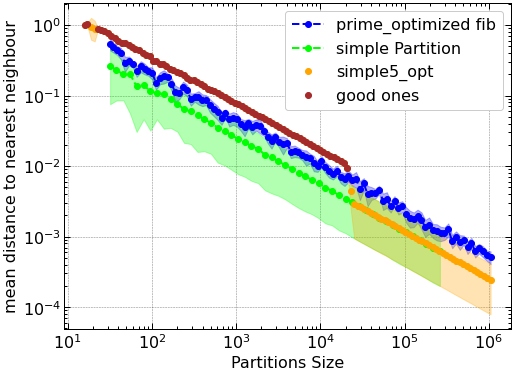

In [14]:
xdata = []
ydata = []
dat_std = []

for res in prime_opt_lattices_res:
    xdata.append(len(res[0]))
    ydata.append(res[2][0])
    dat_std.append(res[3][0])
ydata = np.array(ydata)
dat_std = np.array(dat_std)


plt.plot(xdata, ydata, "o--", label="prime_optimized fib", color = "blue")
plt.fill_between(xdata, ydata-dat_std,ydata+dat_std, color="blue", alpha=0.3)
plt.plot(sizes, simple_means, "o--", label="simple Partition", color = "lime")
plt.fill_between(sizes, simple_means-simple_std,simple_means+simple_std, color="lime", alpha=0.3)
#plt.plot(opt_lattices_means.T[0], opt_lattices_means.T[1], "o", label="optimized fib")
#plt.plot(simpl_opt_lattices_means.T[0], simpl_opt_lattices_means.T[1], "o", label="simple_opt")
#plt.plot(simpl_opt_lattices2_means.T[0], simpl_opt_lattices2_means.T[1], "o", label="simple2_opt")
#plt.plot(simpl_opt_lattices3_means.T[0], simpl_opt_lattices3_means.T[1], "o", label="simple3_opt")
#plt.plot(simpl_opt_lattices4_means.T[0], simpl_opt_lattices4_means.T[1], "o", label="simple4_opt")
plt.plot(simpl_opt_lattices5_means.T[0], simpl_opt_lattices5_means.T[1], "o", label="simple5_opt", color="orange")
means = simpl_opt_lattices5_means.T[1]
std = simpl_opt_lattices5_means.T[2]
plt.fill_between(simpl_opt_lattices5_means.T[0], means-std,means+std, color="orange", alpha=0.3)

plt.plot(filtered_simpl_opt_lattices5_means.T[0], filtered_simpl_opt_lattices5_means.T[1], "o", label="good ones", color="brown")
means = filtered_simpl_opt_lattices5_means.T[1]
std = filtered_simpl_opt_lattices5_means.T[2]
plt.fill_between(filtered_simpl_opt_lattices5_means.T[0], means-std,means+std, color="brown", alpha=0.3)


plt.xlabel("Partitions Size")
plt.ylabel("mean distance to nearest neighbour")
plt.xscale("log")
plt.yscale("log")
plt.legend()
#plt.savefig("standart_deviation_might_be_the_way_to_go.pdf")

In [15]:
ks = [[0,0,0], [0.1,0,0],[0.5,0,0]]


res = np.zeros((len(filtered_simpl_opt_lattices5[::3]), len(ks)))
for i, lattice in enumerate(filtered_simpl_opt_lattices5[::3]):
    print(f"{i}/{len(filtered_simpl_opt_lattices5[::3])}")
    comm = test_angular_momentum_comutator(lattice, 1,i=1, j=1, ang=new_angular_momentum_sparce)
    for i_k, k in enumerate(ks):
        vec = fourier_vector(lattice, 1, k)
        res[i,i_k] = calc_r(comm, vec)


0/26
1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26


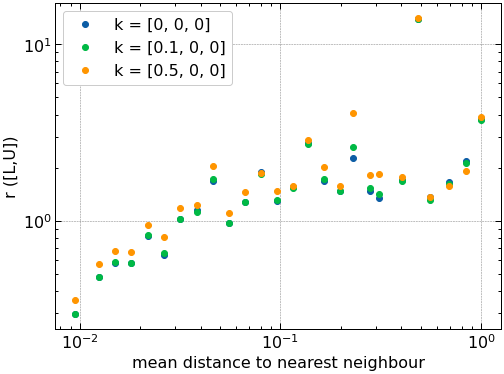

In [21]:
for i,k in enumerate(ks):
    plt.plot(filtered_simpl_opt_lattices5_means[::3].T[1], res[:,i], "o", label=f"k = {k}")

plt.xlabel("mean distance to nearest neighbour")
plt.ylabel("r ([L,U])")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [9]:
from scipy.optimize import curve_fit

In [10]:
with open("prime_opt_fit_params.pickle", "rb") as file:
    params, errors = pickle.load(file)

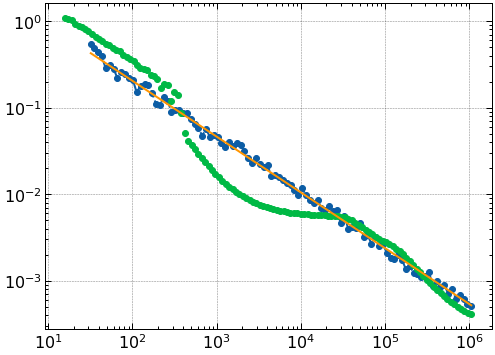

In [11]:
def fit_func(x, a, b):
    return a * x**b


popt, pcov = curve_fit(fit_func, xdata[20:], ydata[20:])
errors = np.diag(pcov)

with open("prime_opt_fit_params.pickle", "wb") as file:
    pickle.dump([popt, errors], file)
with open("prime_opt_fit_params.pickle", "rb") as file:
    popt,errors = pickle.load(file)

plt.plot(xdata, ydata, "o--")
plt.plot(a.T[0], a.T[1], "o")
plt.plot(xdata, fit_func(xdata,*popt))
plt.xscale("log")
plt.yscale("log")

In [8]:

numbers = np.geomspace(2**5, 2**20, num, dtype=int, endpoint=True)
prime_optimised = []
prime_optimised_sig = []
for data in prime_opt_lattices_res:
    prime_optimised.append(data[1] - data[2][0])
    prime_optimised_sig.append(data[3][0])

In [9]:
num = 100

numbers, angles, res = compare_optimization(num, End = 2**20, irationals=[np.sqrt(2), np.sqrt(3)])
p2_p3_res = res.copy()

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "c:\Users\Dominik_Rolfes\anaconda3\lib\multiprocessing\util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "c:\Users\Dominik_Rolfes\anaconda3\lib\multiprocessing\pool.py", line 729, in _terminate_pool
    p.join()
  File "c:\Users\Dominik_Rolfes\anaconda3\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\Dominik_Rolfes\anaconda3\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


In [ ]:


normal_optimised = []
for data in res:
    normal_optimised.append(data[1] - data[2][0])

In [ ]:
num = 100
numbers, angles, res = compare_optimization(num, End = 2**20, irationals=[np.sqrt(3), np.sqrt(5)])

p3_p5_optimised = []
for data in res:
    p3_p5_optimised.append(data[1] - data[2][0])
p3_p5_res = res.copy()

-- angles done --


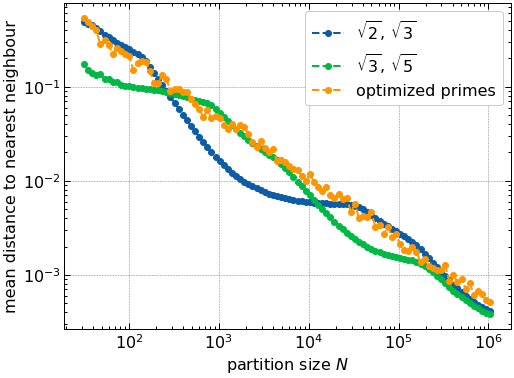

In [ ]:
temp1 = []
temp2 = []
temp3 = []

for (data1, data2, data3) in zip(prime_opt_lattices_res, p2_p3_res, p3_p5_res):
    temp1.append(data1[2][0])
    temp2.append(data2[2][0])
    temp3.append(data3[2][0])

numbers = np.geomspace(2**5, 2**20, num, dtype=int, endpoint=True)
#plt.fill_between(numbers, np.array(prime_optimised)-np.array(prime_optimised_sig), np.array(prime_optimised)+np.array(prime_optimised_sig), )
plt.plot(numbers, temp2, "o--", label = r"$\sqrt{2},\,\sqrt{3}$")
plt.plot(numbers, temp3, "o--", label = r"$\sqrt{3},\,\sqrt{5}$")
plt.plot(numbers, temp1, "o--", label = "optimized primes")

plt.xlabel(r"partition size $N$")
plt.ylabel("mean distance to nearest neighbour")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best")
#plt.savefig("mean_distance_to_closest_neighbor.pdf", dpi=540)

In [ ]:
num = 100
numbers, angles, res = compare_optimization(num, End = 2**20, irationals=[np.sqrt(2), np.sqrt(5)])

p2_p5_optimised = []
for data in res:
    p2_p5_optimised.append(data[1] - data[2][0])

-- angles done --


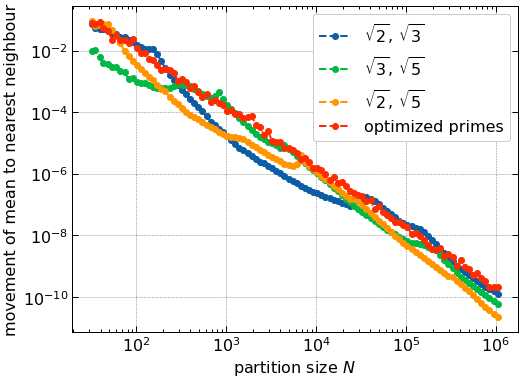

In [25]:
numbers = np.geomspace(2**5, 2**20, num, dtype=int, endpoint=True)
#plt.fill_between(numbers, np.array(prime_optimised)-np.array(prime_optimised_sig), np.array(prime_optimised)+np.array(prime_optimised_sig), )
plt.plot(numbers, normal_optimised, "o--", label = r"$\sqrt{2},\,\sqrt{3}$")
plt.plot(numbers, p3_p5_optimised, "o--", label = r"$\sqrt{3},\,\sqrt{5}$")
plt.plot(numbers, p2_p5_optimised, "o--", label = r"$\sqrt{2},\,\sqrt{5}$")
plt.plot(numbers, prime_optimised, "o--", label = "optimized primes")

plt.xlabel(r"partition size $N$")
plt.ylabel("movement of mean to nearest neighbour")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best")
plt.savefig("optimizing_different_points_groups.pdf", dpi=540)

In [ ]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt

def P_ref(beta):
    ''' 
    generates P_ref according to the strong and weak coupling expansion
    '''
    P = 0
    if beta < 1.21:
        koeffs = [1/4, -1/96, 7/1536, -31/23040, 4451/8847360, 
                    -264883/1486356480, 403651/5945425920,
                    -1826017873/68491306598400]
        for i in range(0,8):
            P += koeffs[i]*beta**(2*i-1)
    else:
        koeffs = [0.7498,0.1511,0.1427,0.1747,0.2435,0.368,0.5884,
                    0.98,1.6839,2.9652,5.326,9.7234,17.995,33.690,63.702]
        for i in range(1,16):
            P += koeffs[i-1]/beta**i
    return P


betas = np.linspace(0.1,10,20)
P_r = [P_ref(beta) for beta in betas]


path = pathlib.Path("su2mc_cpp/tmp_7000sweeps_5000thrown")

#np.loadtxt("fib_16.csv")
fig, axes = plt.subplots(12,2,figsize=(20,60))
for i in range(4,16):
    ax1 = axes[i-4][0]
    ax2 = axes[i-4][1]
    fib = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(1))
    fib_sig = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(2))
    opt = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(1))
    opt_sig = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(2))
    
    ax1.plot(betas, fib, "o--", label=f"fib_{2**i}")
    ax1.plot(betas, opt, "o--", label=f"opt_{2**i}")
    ax2.plot(betas, (opt-fib), label="diff")
    ax2.set_yscale("symlog", linthresh=1e-5)
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax1.set_xlabel(r"$\beta$")
    ax1.set_ylabel(r"P")
    ax2.set_xlabel(r"$\beta$")
plt.show()

In [ ]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots

def P_ref(beta):
    ''' 
    generates P_ref according to the strong and weak coupling expansion
    '''
    P = 0
    if beta < 1.21:
        koeffs = [1/4, -1/96, 7/1536, -31/23040, 4451/8847360, 
                    -264883/1486356480, 403651/5945425920,
                    -1826017873/68491306598400]
        for i in range(0,8):
            P += koeffs[i]*beta**(2*i-1)
    else:
        koeffs = [0.7498,0.1511,0.1427,0.1747,0.2435,0.368,0.5884,
                    0.98,1.6839,2.9652,5.326,9.7234,17.995,33.690,63.702]
        for i in range(1,16):
            P += koeffs[i-1]/beta**i
    return P


betas = np.linspace(0.1,10,100)
P_r = [P_ref(beta) for beta in betas]


path = pathlib.Path("su2mc_cpp/tmp_8000sweeps_5000thrown_fine")

#np.loadtxt("fib_16.csv")
fig, axes = plt.subplots(10,2,figsize=(20,60))
for i in range(4,14):
    ax1 = axes[i-4][0]
    ax2 = axes[i-4][1]
    fib = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(1))
    fib_sig = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(2))
    opt = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(1))
    opt_sig = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(2))
    
    ax1.plot(betas, fib, "o--", label=f"fib_{2**i}")
    ax1.plot(betas, opt, "o--", label=f"opt_{2**i}")
    ax2.plot(betas, abs(opt-fib), label="diff")
    #ax2.set_yscale("symlog", linthresh=1e-5)
    ax2.set_yscale("log")#, linthresh=1e-5)
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax1.set_xlabel(r"$\beta$")
    ax1.set_ylabel(r"P")
    ax2.set_xlabel(r"$\beta$")
plt.show()